# IBM´s API is a mess
## At least the parts concerning actually simulating the execution of a quantum circuit
### I swear I spent *months* trying to understand the different ways to "run" 

## Preface: things that don´t work
- `execute` method has been deprecated. Every pice of code that an LLM or online forum shows that includes something like `job = execute(circuit, backend)` is outdated and will not work. Source: https://docs.quantum.ibm.com/api/qiskit/0.46/execute, https://stackoverflow.com/questions/78027912/unable-to-import-execute-function-from-qiskit-library

In [15]:
# Import Aer, transpile and execute
from qiskit import transpile
from qiskit_aer import AerSimulator  # as of 25Mar2025

from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit.quantum_info import Operator
import sys
sys.path.append('../') # Relative imports in jupyter notebooks are also a mess, but that´s a whole other story
from Hamiltonians_and_Lindbladians.utils_hamiltonian_simulation import *
from qiskit.visualization import plot_histogram, plot_state_city



## Things that do work
- 1:  Qiskit Aer simulator backend

Example 1: preparing a Bell state and measuring it

<IPython.core.display.Latex object>


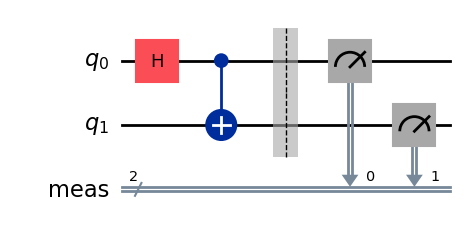

In [ ]:
qc_bell_stae = QuantumCircuit(2)
qc_bell_stae.h(0)
qc_bell_stae.cx(0, 1)
bell_state = Statevector.from_instruction(qc_bell_stae)
qc_bell_stae.measure_all()
qc_bell_stae.draw('mpl')

In [ ]:
bell_state.draw('latex')

<IPython.core.display.Latex object>

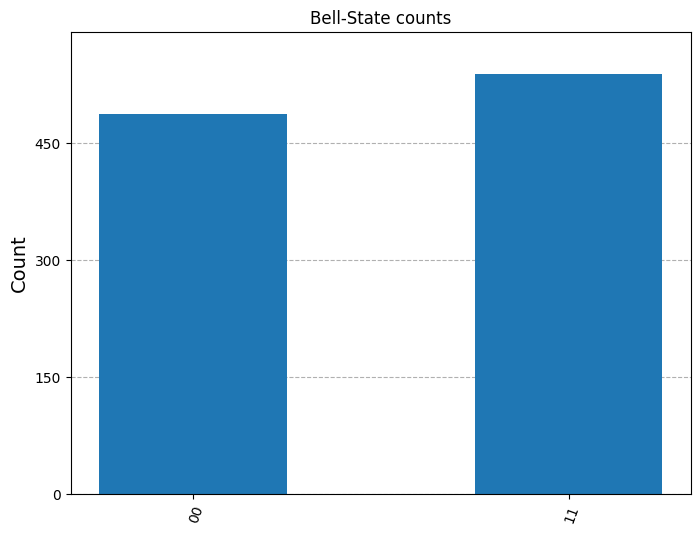

In [17]:
simulator_1 = AerSimulator()
transpiled_circuit = transpile(qc_bell_stae, simulator_1)
job = simulator_1.run(transpiled_circuit)
result = job.result()
counts = result.get_counts()
plot_histogram(counts, title='Bell-State counts', figsize=(8,6), bar_labels=False)


In [18]:
AerSimulator().available_methods()

('automatic',
 'statevector',
 'density_matrix',
 'stabilizer',
 'matrix_product_state',
 'extended_stabilizer',
 'unitary',
 'superop')

In [19]:
AerSimulator().available_devices()

('CPU',)

Method: automatic
Counts: {'11': 506, '00': 518}

Method: statevector
Counts: {'00': 524, '11': 500}

Method: density_matrix
Counts: {'11': 514, '00': 510}

Method: stabilizer
Counts: {'00': 500, '11': 524}

Method: matrix_product_state
Counts: {'00': 508, '11': 516}

Method: extended_stabilizer
Counts: {'00': 491, '11': 533}

Method: unitary
Error: 'ERROR:  [Experiment 0] Circuit circuit-175 contains invalid instructions {"instructions": {measure}} for "unitary" method.Circuit circuit-175 contains invalid parameters  for "unitary" method. ,  ERROR: Circuit circuit-175 contains invalid instructions {"instructions": {measure}} for "unitary" method.Circuit circuit-175 contains invalid parameters  for "unitary" method.'
Method: superop
Error: 'ERROR:  [Experiment 0] Circuit circuit-175 contains invalid instructions {"instructions": {measure}} for "superop" method.Circuit circuit-175 contains invalid parameters  for "superop" method. ,  ERROR: Circuit circuit-175 contains invalid instructi

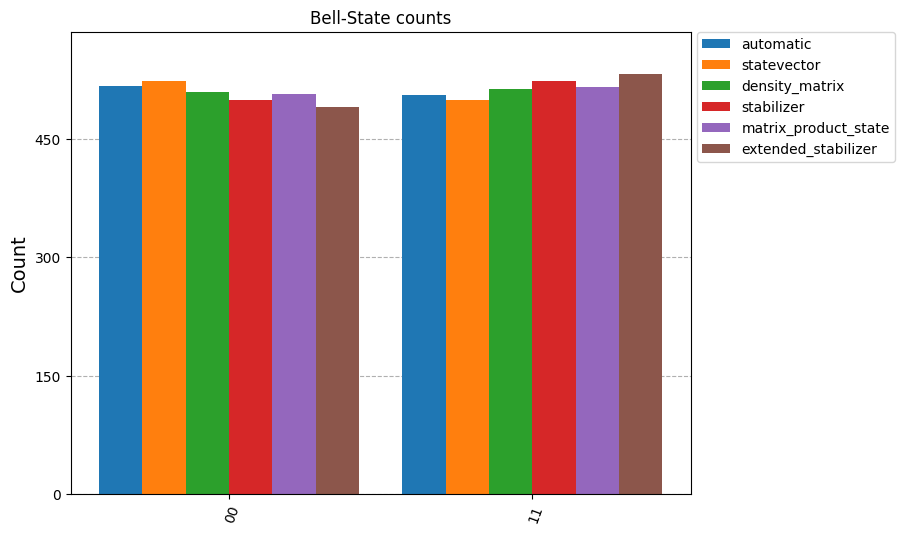

In [32]:
def try_all_simulation_methods(qc : QuantumCircuit):
    results = {}
    for simulation_method in AerSimulator().available_methods():
        print(f"Method: {simulation_method}")
        simulator = AerSimulator(method=simulation_method)
        transpiled_circuit = transpile(qc, simulator)
        job = simulator.run(transpiled_circuit)
        result = job.result()
        try:
            counts = result.get_counts()
        except Exception as e:
            print(f"Error: {e}")
            continue                               
        print(f"Counts: {counts}\n")
        results[simulation_method] = counts
    return results

results = try_all_simulation_methods(qc_bell_stae)

plot_histogram([counts for counts in results.values()], title='Bell-State counts', figsize=(8,6), bar_labels=False, legend=list(results.keys()))


## Example circuit: Phase Estimation based on Quantum Fourier Transform (QFT)

In [105]:
def standard_qpe(unitary: Operator, eigenstate: QuantumCircuit, num_ancilla: int) -> QuantumCircuit:
    """Constructs a standard Quantum Phase Estimation (QPE) circuit using repeated controlled-U applications."""
    num_qubits = unitary.num_qubits
    qc = QuantumCircuit(num_ancilla + num_qubits, num_ancilla)

    # Prepare eigenstate on system qubits
    qc.append(eigenstate, range(num_ancilla, num_ancilla + num_qubits))

    # Apply Hadamard gates to ancilla qubits
    qc.h(range(num_ancilla))

    # Apply controlled-U^(2^k) using repeated controlled applications of U
    for k in range(num_ancilla):
        controlled_U = UnitaryGate(unitary.data).control(1, label=f"U")
        
        # Apply controlled-U 2^k times
        for _ in range(2**k):  
            qc.append(controlled_U, [k] + list(range(num_ancilla, num_ancilla + num_qubits)))

    # Apply inverse QFT on ancilla qubits
    qc.append(QFT(num_ancilla, inverse=True), range(num_ancilla))

    # Measure ancilla qubits
    qc.measure(range(num_ancilla), range(num_ancilla))

    return qc


Hamiltonian: SparsePauliOp(['I', 'X', 'Z', 'I'],
              coeffs=[0.62874004+0.j, 0.5557843 +0.j, 0.00453848+0.j, 0.42790629+0.j])
 Unitary: Operator([[ 0.41401717+0.74176798j, -0.459394  +0.25947487j],
          [-0.459394  +0.25947487j,  0.4215199 +0.73753028j]],
         input_dims=(2,), output_dims=(2,))
 Eigenvalues: [0.5008435  1.61244915]
 Eigenvectors: [[ 0.70421388+0.j -0.7099879 +0.j]
 [-0.7099879 +0.j -0.70421388+0.j]]
 Ground state: [ 0.70421388+0.j -0.7099879 +0.j]


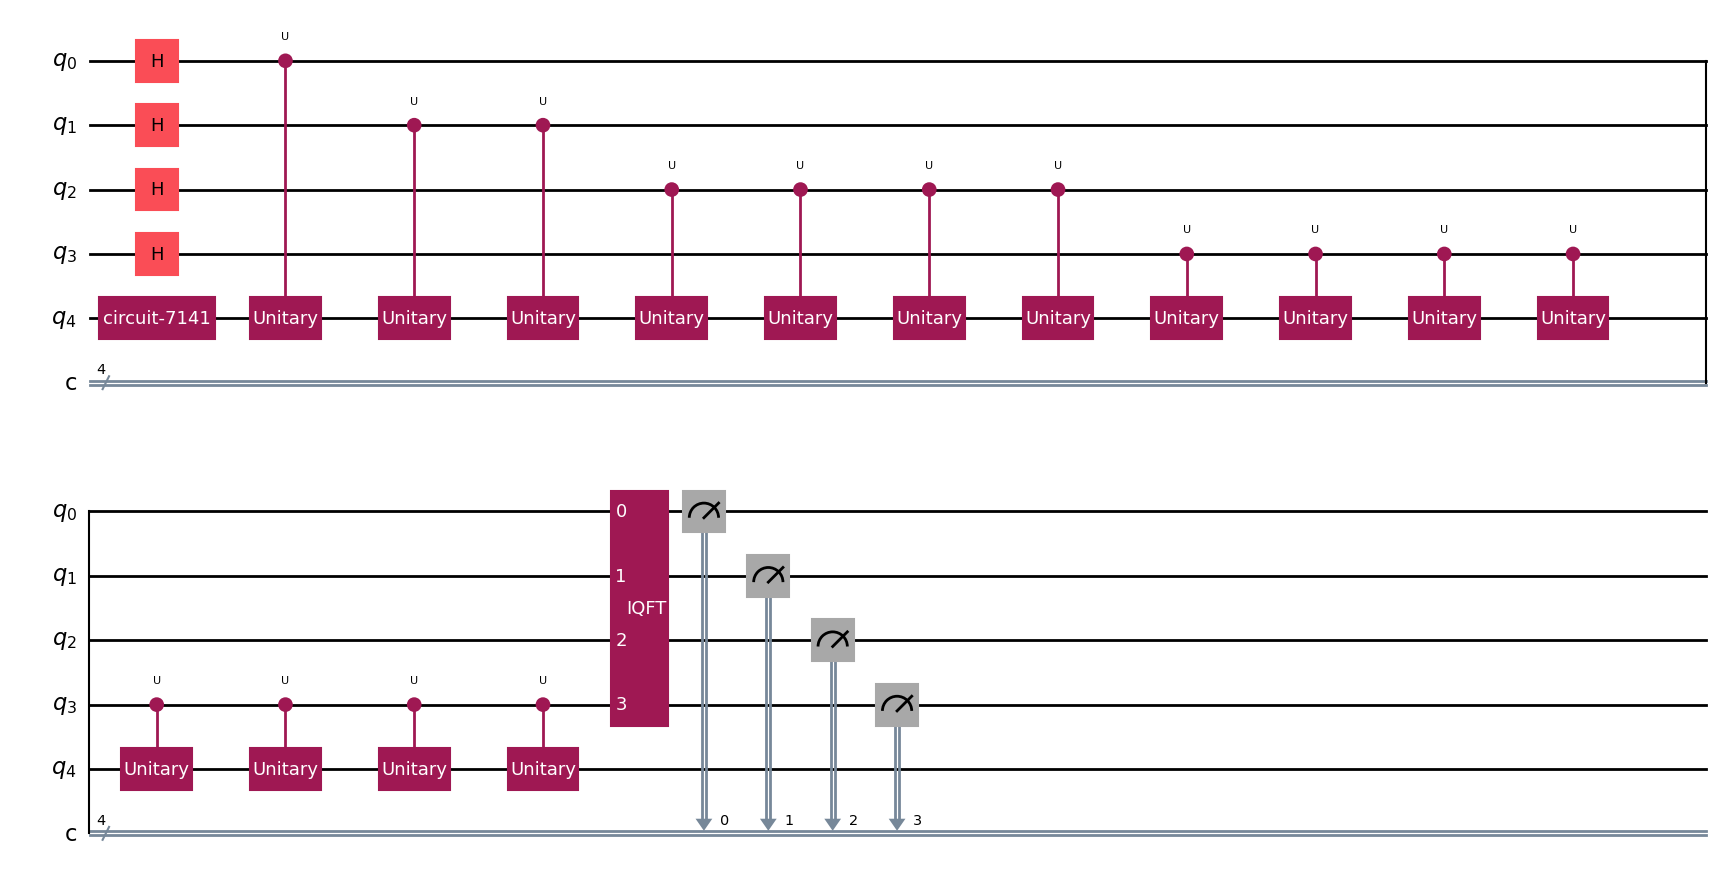

In [172]:
# Define the unitary operator e^{i * pi * H} for a random Hamiltonian
def exponentiate_hamiltonian(hamiltonian: SparsePauliOp, time: float) -> Operator:
    """Exponentiates the Hamiltonian to obtain U = e^(-i H t)."""
    matrix = hamiltonian.to_matrix()
    unitary_matrix = scipy.linalg.expm(1j * time * matrix)
    return Operator(unitary_matrix)

t = 1
H = construct_hamiltonian(generate_random_hamiltonian(num_qubits=1, num_terms=4))
U = exponentiate_hamiltonian(H, time=t)
eigenvalues, eigenvectors = get_eigenvalues_vectors(H)
# ground state is the eigenvector corresponding to the smallest eigenvalue
ground_eigenstate = eigenvectors[:, np.argmin(eigenvalues)]
print(f"Hamiltonian: {H}\n Unitary: {U}\n Eigenvalues: {eigenvalues}\n Eigenvectors: {eigenvectors}\n Ground state: {ground_eigenstate}")
qc_qpe = standard_qpe(U, QuantumCircuit(1), 4)
qc_qpe.draw('mpl')

In [173]:
simulator_sv = AerSimulator(method='statevector')
transpiled_circuit = transpile(qc_qpe, simulator_sv)
result = simulator_sv.run(transpiled_circuit).result()
counts = result.get_counts()

most_common_bitstring = max(counts, key=counts.get)
print(f"Most common bitstring: {most_common_bitstring}")
# print the two closest bitstrings to the most common one, in terms of binary distance. For example, if the most common bitstring is '101', the two closest ones are '100' and '111'
closest_bigger_bitstring = bin(int(most_common_bitstring, 2) + 1) # this is the python binary representation of the integer obtained by adding 1 to the most common bitstring
closest_smaller_bitstring = bin(int(most_common_bitstring, 2) - 1) # this is the python binary representation of the integer obtained by subtracting 1 to the most common bitstring
print(f"Closest bigger bitstring: {closest_bigger_bitstring}")
print(f"Closest smaller bitstring: {closest_smaller_bitstring}")
phase_decimal = int(most_common_bitstring, 2) /  ((2 ** len(most_common_bitstring)) * t)
closest_bigger_phase_decimal = int(closest_bigger_bitstring, 2) /  ((2 ** len(closest_bigger_bitstring)) * t)
closest_smaller_phase_decimal = int(closest_smaller_bitstring, 2) /  ((2 ** len(closest_smaller_bitstring)) * t)
print(f"Estimated phase: {phase_decimal}")
print(f"Closest bigger estimated phase: {closest_bigger_phase_decimal}")
print(f"Closest smaller estimated phase: {closest_smaller_phase_decimal}")

print(f"True phase: {eigenvalues[0]}")



Most common bitstring: 0100
Closest bigger bitstring: 0b101
Closest smaller bitstring: 0b11
Estimated phase: 0.25
Closest bigger estimated phase: 0.15625
Closest smaller estimated phase: 0.1875
True phase: 0.5008435020929629


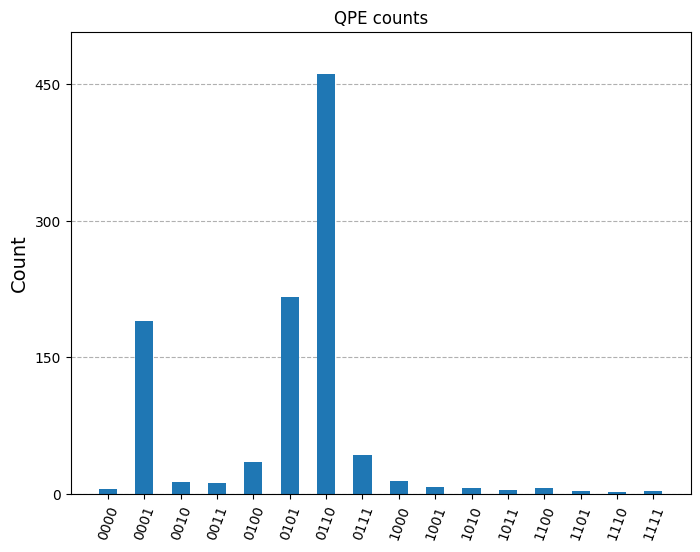

In [154]:

plot_histogram(counts, title='QPE counts', figsize=(8,6), bar_labels=False)